# Feature Engineering for Credit Scoring

This notebook performs feature engineering on the Home Credit Default Risk dataset.

## Overview
- **Input**: 7 raw CSV files from Home Credit dataset
- **Output**: Single processed feature file (`data/processed/features_train.pkl`)
- **Features**: 700+ engineered features from all data sources

## Data Sources
1. `application_train.csv` - Main application data with TARGET
2. `bureau.csv` - Previous credits from other institutions
3. `bureau_balance.csv` - Monthly bureau balance history
4. `previous_application.csv` - Previous Home Credit applications
5. `POS_CASH_balance.csv` - POS and cash loan balances
6. `installments_payments.csv` - Payment history
7. `credit_card_balance.csv` - Credit card balances

## Key Adaptations
- Only uses training data (test set has no target variable)
- Feature names cleaned for LightGBM compatibility
- Handles class imbalance (addressed in model training notebook)


## 1. Setup and Configuration


In [27]:
import sys
from pathlib import Path

# Add parent directory to path for imports
parent_dir = Path().resolve().parent
sys.path.insert(0, str(parent_dir))

import numpy as np
import pandas as pd
import gc
import time
import re
import pickle
from contextlib import contextmanager
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data paths
DATA_PATH = Path("../src/data/input")
OUTPUT_PATH = Path("../data/processed")
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

@contextmanager
def timer(title):
    """Context manager for timing code blocks"""
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

print("Imports and configuration complete")
print(f"Input data path: {DATA_PATH}")
print(f"Output path: {OUTPUT_PATH}")


Imports and configuration complete
Input data path: ../src/data/input
Output path: ../data/processed


## 2. Helper Functions


In [28]:
def one_hot_encoder(df, nan_as_category=True):
    """One-hot encoding for categorical columns with get_dummies"""
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


def clean_feature_names(df):
    """
    Clean feature names to be compatible with LightGBM.
    LightGBM doesn't support special JSON characters in feature names.
    """
    # Replace special characters with underscores
    new_columns = {}
    for col in df.columns:
        # Replace characters that LightGBM doesn't like
        new_col = re.sub(r'[^A-Za-z0-9_]', '_', str(col))
        # Remove multiple consecutive underscores
        new_col = re.sub(r'_+', '_', new_col)
        # Remove leading/trailing underscores
        new_col = new_col.strip('_')
        new_columns[col] = new_col
    
    df = df.rename(columns=new_columns)
    return df


def safe_divide(numerator, denominator, fill_value=np.nan):
    """
    Division sécurisée qui remplace les infinis par fill_value.
    """
    result = numerator / denominator
    result = result.replace([np.inf, -np.inf], fill_value)
    return result


## 3. Application Data Processing

Process the main application training data with basic feature engineering.


In [29]:
def application_train(num_rows=None, nan_as_category=False):
    """
    Preprocess application_train.csv.
    
    Args:
        num_rows: Number of rows to read (None for all)
        nan_as_category: Whether to treat NaN as a category in one-hot encoding
    
    Returns:
        Preprocessed DataFrame with engineered features
    """
    # Read only training data
    df = pd.read_csv(DATA_PATH / 'application_train.csv', nrows=num_rows)
    print(f"Train samples: {len(df)}")
    
    # Remove 4 applications with XNA CODE_GENDER
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan (anomalous value)
    df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].replace(365243, np.nan)
    
    # Feature engineering: create new ratio features
    df['DAYS_EMPLOYED_PERC'] = safe_divide(df['DAYS_EMPLOYED'], df['DAYS_BIRTH'])
    df['INCOME_CREDIT_PERC'] = safe_divide(df['AMT_INCOME_TOTAL'], df['AMT_CREDIT'])
    df['INCOME_PER_PERSON'] = safe_divide(df['AMT_INCOME_TOTAL'], df['CNT_FAM_MEMBERS'])
    df['ANNUITY_INCOME_PERC'] = safe_divide(df['AMT_ANNUITY'], df['AMT_INCOME_TOTAL'])
    df['PAYMENT_RATE'] = safe_divide(df['AMT_ANNUITY'], df['AMT_CREDIT'])

    
    gc.collect()
    return df


print("application_train() function defined")


application_train() function defined


## 4. Bureau Data Processing

Process bureau.csv and bureau_balance.csv - previous credits from other financial institutions.


In [30]:
def bureau_and_balance(num_rows=None, nan_as_category=True):
    """
    Preprocess bureau.csv and bureau_balance.csv with aggregations.
    Creates features for active and closed credits separately.
    """
    bureau = pd.read_csv(DATA_PATH / 'bureau.csv', nrows=num_rows)
    bb = pd.read_csv(DATA_PATH / 'bureau_balance.csv', nrows=num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat:
        cat_aggregations[cat] = ['mean']
    for cat in bb_cat:
        cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
    # Bureau: Active credits
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    
    # Bureau: Closed credits
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    
    return bureau_agg


print(" bureau_and_balance() function defined")


 bureau_and_balance() function defined


## 5. Previous Applications Processing

Process previous_application.csv - all previous Home Credit loan applications.


In [31]:
def previous_applications(num_rows=None, nan_as_category=True):
    """
    Preprocess previous_application.csv with aggregations.
    Creates separate features for approved and refused applications.
    """
    prev = pd.read_csv(DATA_PATH / 'previous_application.csv', nrows=num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)
    
    # Days 365.243 values -> nan (anomalous values)
    for col in ['DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 
                'DAYS_LAST_DUE', 'DAYS_TERMINATION']:
        prev[col] = prev[col].replace(365243, np.nan)
    
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = safe_divide(prev['AMT_APPLICATION'], prev['AMT_CREDIT'])

    
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    
    # Previous Applications: Approved Applications
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    
    # Previous Applications: Refused Applications
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg


print(" previous_applications() function defined")


 previous_applications() function defined


## 6. POS Cash Balance Processing

Process POS_CASH_balance.csv - monthly POS and cash loan balance snapshots.


In [32]:
def pos_cash(num_rows=None, nan_as_category=True):
    """
    Preprocess POS_CASH_balance.csv with aggregations.
    """
    pos = pd.read_csv(DATA_PATH / 'POS_CASH_balance.csv', nrows=num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)
    
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg


print("pos_cash() function defined")


pos_cash() function defined


## 7. Installments Payments Processing

Process installments_payments.csv - repayment history for previously disbursed credits.


In [33]:
def installments_payments(num_rows=None, nan_as_category=True):
    """
    Preprocess installments_payments.csv with aggregations.
    Creates payment behavior features like DPD (days past due) and DBD (days before due).
    """
    ins = pd.read_csv(DATA_PATH / 'installments_payments.csv', nrows=num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category=True)
    
    # Percentage and difference paid in each installment
    ins['PAYMENT_PERC'] = safe_divide(ins['AMT_PAYMENT'], ins['AMT_INSTALMENT'])
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].clip(lower=0)
    ins['DBD'] = ins['DBD'].clip(lower=0)
    
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg


print("installments_payments() function defined")


installments_payments() function defined


## 8. Credit Card Balance Processing

Process credit_card_balance.csv - monthly credit card balance snapshots.


In [34]:
def credit_card_balance(num_rows=None, nan_as_category=True):
    """
    Preprocess credit_card_balance.csv with aggregations.
    """
    cc = pd.read_csv(DATA_PATH / 'credit_card_balance.csv', nrows=num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category=True)
    
    # Drop SK_ID_PREV
    cc.drop(['SK_ID_PREV'], axis=1, inplace=True)
    
    # Separate numeric and categorical columns for different aggregations
    numeric_cols = [col for col in cc.columns if col not in ['SK_ID_CURR'] + cat_cols]
    
    # Aggregations for numeric columns
    num_aggregations = {col: ['min', 'max', 'mean', 'sum', 'var'] for col in numeric_cols}
    
    # Aggregations for categorical columns (only mean for one-hot encoded)
    cat_aggregations = {col: ['mean'] for col in cat_cols}
    
    # Combine aggregations
    all_aggregations = {**num_aggregations, **cat_aggregations}
    
    cc_agg = cc.groupby('SK_ID_CURR').agg(all_aggregations)
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg


print(" credit_card_balance() function defined")


 credit_card_balance() function defined


## 9. Run Feature Engineering Pipeline

Execute all feature engineering steps and merge into a single dataset.


In [35]:
def run_feature_engineering(debug=False):
    """
    Run the complete feature engineering pipeline.
    
    Args:
        debug: If True, use subset of data (10k rows) for faster testing
    
    Returns:
        DataFrame with all engineered features
    """
    num_rows = 10000 if debug else None
    
    print("=" * 60)
    print("FEATURE ENGINEERING PIPELINE")
    print("=" * 60)
    print(f"Mode: {'DEBUG (10k rows)' if debug else 'FULL DATA'}")
    print("=" * 60)
    
    # Load and preprocess main application data
    with timer("Process application_train"):
        df = application_train(num_rows)
        print(f"Application df shape: {df.shape}")

    # Join with bureau data
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print(f"Bureau df shape: {bureau.shape}")
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()

    # Join with previous applications
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print(f"Previous applications df shape: {prev.shape}")
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()

    # Join with POS-CASH balance
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print(f"Pos-cash balance df shape: {pos.shape}")
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()

    # Join with installments payments
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print(f"Installments payments df shape: {ins.shape}")
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()

    # Join with credit card balance
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print(f"Credit card balance df shape: {cc.shape}")
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()

    # Clean feature names for LightGBM compatibility
    with timer("Clean feature names"):
        df = clean_feature_names(df)
        print(" Feature names cleaned for LightGBM compatibility")
    
    return df


In [36]:
# Configuration
DEBUG_MODE = False # Set to False for full data processing

# Run the pipeline
with timer("Full feature engineering pipeline"):
    df = run_feature_engineering(debug=DEBUG_MODE)

print("\n" + "=" * 60)
print("FEATURE ENGINEERING COMPLETE")
print("=" * 60)
print(f"Final dataset shape: {df.shape}")
print(f"📊 Number of features: {df.shape[1] - 2}")  # Minus TARGET and SK_ID_CURR
print(f"📊 Target distribution:")
print(df['TARGET'].value_counts())
print(f"\n📊 Class imbalance ratio: {(df['TARGET'] == 0).sum() / (df['TARGET'] == 1).sum():.2f}:1")


FEATURE ENGINEERING PIPELINE
Mode: FULL DATA


Train samples: 307511
Application df shape: (307507, 247)
Process application_train - done in 3s
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 14s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 14s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 8s
Installments payments df shape: (339587, 26)
Process installments payments - done in 13s
Credit card balance df shape: (103558, 109)
Process credit card balance - done in 12s
 Feature names cleaned for LightGBM compatibility
Clean feature names - done in 2s
Full feature engineering pipeline - done in 67s

FEATURE ENGINEERING COMPLETE
Final dataset shape: (307507, 765)
📊 Number of features: 763
📊 Target distribution:
TARGET
0    282682
1     24825
Name: count, dtype: int64

📊 Class imbalance ratio: 11.39:1


## 10. Save Processed Features


In [37]:
# Save features as pickle file
output_file = OUTPUT_PATH / "features_train.pkl"

with timer("Save features to pickle"):
    with open(output_file, 'wb') as f:
        pickle.dump(df, f)
    print(f"✅ Features saved to: {output_file}")
    print(f"   File size: {output_file.stat().st_size / 1024 / 1024:.2f} MB")

# Also save feature names for reference
import json
exclude_cols = ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']
feature_names = [col for col in df.columns if col not in exclude_cols]

feature_names_file = OUTPUT_PATH / "feature_names.json"
with open(feature_names_file, 'w') as f:
    json.dump({
        "feature_names": feature_names,
        "n_features": len(feature_names),
        "exclude_cols": exclude_cols
    }, f, indent=2)
print(f"✅ Feature names saved to: {feature_names_file}")
print(f"   Number of features: {len(feature_names)}")


✅ Features saved to: ../data/processed/features_train.pkl
   File size: 1524.11 MB
Save features to pickle - done in 5s
✅ Feature names saved to: ../data/processed/feature_names.json
   Number of features: 763


## 11. Feature Summary and Visualization


In [38]:
# Display summary statistics
print("=" * 60)
print("FEATURE SUMMARY")
print("=" * 60)

# Missing values summary
missing_pct = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
print(f"\n📊 Top 10 features with missing values:")
print(missing_pct.head(10))

# Feature types
print(f"\n📊 Feature types:")
print(df.dtypes.value_counts())

# Memory usage
print(f"\n📊 Memory usage: {df.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")


FEATURE SUMMARY

📊 Top 10 features with missing values:
REFUSED_RATE_DOWN_PAYMENT_MAX        85.311554
REFUSED_AMT_DOWN_PAYMENT_MAX         85.311554
REFUSED_RATE_DOWN_PAYMENT_MEAN       85.311554
REFUSED_RATE_DOWN_PAYMENT_MIN        85.311554
REFUSED_AMT_DOWN_PAYMENT_MEAN        85.311554
REFUSED_AMT_DOWN_PAYMENT_MIN         85.311554
REFUSED_APP_CREDIT_PERC_VAR          84.014022
CC_AMT_PAYMENT_CURRENT_VAR           80.286953
CC_CNT_DRAWINGS_POS_CURRENT_VAR      80.262888
CC_CNT_DRAWINGS_OTHER_CURRENT_VAR    80.262888
dtype: float64

📊 Feature types:
float64    589
bool       133
int64       43
Name: count, dtype: int64

📊 Memory usage: 1524.08 MB


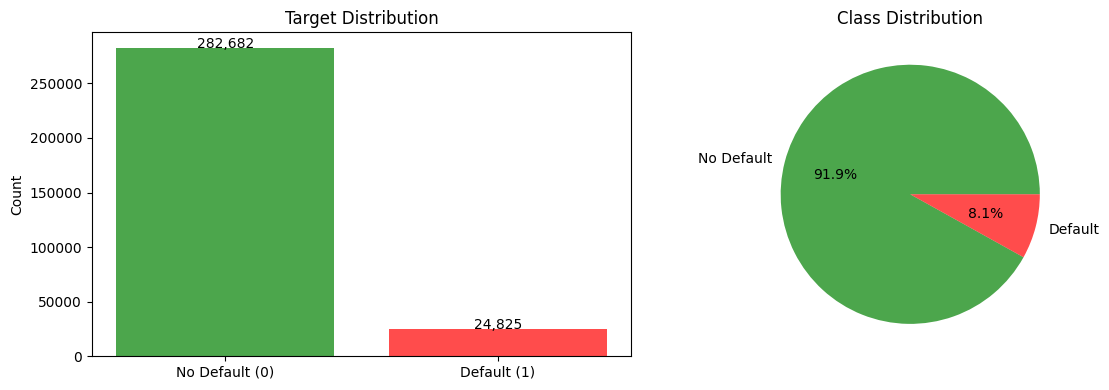


✅ Visualization saved to: ../data/processed/target_distribution.png


In [39]:
# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Target distribution
target_counts = df['TARGET'].value_counts()
axes[0].bar(['No Default (0)', 'Default (1)'], target_counts.values, color=['green', 'red'], alpha=0.7)
axes[0].set_title('Target Distribution')
axes[0].set_ylabel('Count')
for i, v in enumerate(target_counts.values):
    axes[0].text(i, v + 100, f'{v:,}', ha='center')

# Class imbalance pie chart
wedges, texts, autotexts = axes[1].pie(target_counts.values, labels=['No Default', 'Default'], 
                                         autopct='%1.1f%%', colors=['green', 'red'])
# Apply alpha to wedges instead
for wedge in wedges:
    wedge.set_alpha(0.7)
axes[1].set_title('Class Distribution')

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'target_distribution.png', dpi=100, bbox_inches='tight')
plt.show()

print(f"\n✅ Visualization saved to: {OUTPUT_PATH / 'target_distribution.png'}")


## Next Steps

The engineered features have been saved. You can now:

1. **Run Model Training**: Open `03_model_training.ipynb` to train and compare different models
2. **Load Features**: Use the following code to load the processed features:

```python
import pickle
with open('../data/processed/features_train.pkl', 'rb') as f:
    df = pickle.load(f)
```

### Key Notes
- **Class Imbalance**: The dataset has significant class imbalance (~92% no default, ~8% default)
- **Feature Count**: 700+ features from 7 data sources
- **Missing Values**: Many features have missing values - models should handle this
- **Business Metric**: False Negatives (missed defaults) cost 10x more than False Positives


In [40]:
def one_hot_encoder(df, nan_as_category=True):
    """
    One-hot encoding for categorical columns with get_dummies.
    
    Args:
        df: Input DataFrame
        nan_as_category: Whether to treat NaN as a category
    
    Returns:
        df: DataFrame with encoded features
        new_columns: List of new column names created
    """
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


def clean_feature_names(df):
    """
    Clean feature names to be compatible with LightGBM.
    LightGBM doesn't support special JSON characters in feature names.
    
    Args:
        df: Input DataFrame
    
    Returns:
        df: DataFrame with cleaned column names
    """
    new_columns = {}
    for col in df.columns:
        # Replace characters that LightGBM doesn't like
        new_col = re.sub(r'[^A-Za-z0-9_]', '_', str(col))
        # Remove multiple consecutive underscores
        new_col = re.sub(r'_+', '_', new_col)
        # Remove leading/trailing underscores
        new_col = new_col.strip('_')
        new_columns[col] = new_col
    
    df = df.rename(columns=new_columns)
    return df


print("✅ Helper functions defined")


✅ Helper functions defined
